In [1]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt
from scikits.sparse.cholmod import cholesky

%matplotlib inline  

In [2]:
from cvxpy import *
import mosek
import gurobi
import pickle
import dill
import time

In [3]:
# sys.setrecursionlimit(10000)

In [4]:
# dill.load_session(filename='pickle/test_sess.pkl')

In [5]:
results=dill.load( open( "pickle/Stoch_Benders_ieee14_100iter_10loadp_significantmultiplier.p", "rb" ) )
# scenarios_bus=dill.load( open( "pickle/scenarios_bus.p", "rb" ) )
# Constraints=list(dill.load( open( "pickle/Constraints.p", "rb" )))
# Objective=dill.load( open( "pickle/Objective.p", "rb" ) )
# on_off_cost=pickle.load( open( "pickle/on_off_cost.p", "rb" ) )
# variables=dill.load( open( "pickle/variables.p", "rb" ) )
# constants=dill.load( open( "pickle/constants.p", "rb" ) )

In [6]:
# results['time_SS']

In [7]:
# Constraints=list(results['Constraint'])
# Objective=results['Objective']
# variables=results['variables']
# constants=results['constants']

In [8]:
for res in results.keys():
    exec (res + "= results[res]")

In [9]:
for var in variables.keys():
    exec (var + "= variables[var]")
for cons in constants.keys():
    exec (cons + "= constants[cons]")

In [10]:
# p=variables['p']
# w=variables['w']
# s=variables['s']
# load=variables['load']
# gk=variables['gk']


# Load_Penalty=constants['Load_Penalty']
# ontime=constants['ontime']
# H0=constants['H0']
# g0=constants['g0']
# pwl_cost=constants['pwl_cost']
# on_off_cost=constants['on_off_cost']
# p_max=constants['p_max']
# p_min=constants['p_min']
# b=constants['b']
# rampup=constants['rampup']
# rampdown=constants['rampdown']
# w_max=constants['w_max']
# w_min=constants['w_min']
# z_max=constants['z_max']
# z_min=constants['z_min']
# on_off_init=constants['on_off_init']
# pwl_points=constants['pwl_points']
# G=constants['G']
# Dm=constants['Dm']
# R=constants['R']
# A=constants['A']
# n_h=constants['n_h']
# num_p=constants['num_p']

# J=constants['J']
# PWL=constants['PWL']
# on_off_init=constants['on_off_init']
# n_samples=constants['n_samples']
# n_test=constants['n_test']


# scenarios_bus=results['scenarios_bus']

In [11]:
p=Variable(p.size[0],p.size[1])
w=Variable(w.size[0],w.size[1])
s=Variable(s.size[0],s.size[1])
load=Variable(load.size[0],load.size[1])
on_off_param=Parameter(num_p,n_h)
r_parameter=Parameter(s.size[0],s.size[1])


if PWL:
    gk=Variable(gk.size[0],gk.size[1])

on_off_value=np.zeros((num_p,n_h))
on_off_init=np.zeros(num_p)

In [12]:
r=np.mean(scenarios_bus,2)

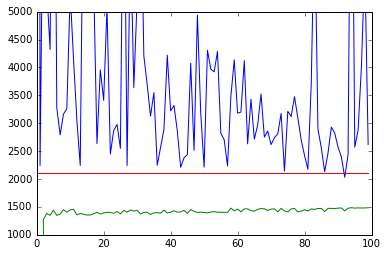

In [13]:
optimal=2111.7#253433
plt.plot(results['upper'][0::])
plt.plot(results['lower'][0::])
plt.plot(range(len(results['upper'])),np.ones(len(results['upper']))*(optimal))
plt.ylim(1e3,5e3)
plt.show()

In [14]:
def eval_obj (on_off,on_off_cost=on_off_cost,n_h=24):
    obj_eval=0
    for i in range(1,n_h):
        obj_eval = obj_eval + np.sum(on_off_cost*np.maximum(on_off[:,i] - on_off[:,i-1],0))
    obj_eval = obj_eval + np.sum((on_off_cost)*np.maximum(on_off[:,0].T - on_off_init,0).T)

#     for i in range (n_h):
#         if PWL:
#             for j in range(pwl_points):
#                 for k in range(num_p):
#                     obj_eval=obj_eval + gk[k+(num_p*j),i]*pwl_cost[k,j]
#         else:
#             obj_eval=obj_eval + 0.5*p[:,i].T*H0*p[:,i]
#             obj_eval=obj_eval + g0*p[:,i]# check 

#         obj_eval=obj_eval + Load_Penalty*np.linalg.norm(load[:,i]-b[:,i],1)
        
    return obj_eval


In [15]:
PWL=True

In [16]:
#         Constraints.append([gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points) for j in range(pwl_points)][0])
#         Constraints.append([gk[num_p*j:num_p*(j+1),i]>=0 for j in range(pwl_points)][0])

In [17]:
# init constraints second stage

Constraints=[]
for i in range (n_h):
    Constraints.append(p[:,i]<=mul_elemwise(p_max[:],on_off_param[:,i]))
for i in range (n_h):
    Constraints.append(p[:,i]>=mul_elemwise(p_min[:],on_off_param[:,i]))
for i in range (n_h):
    Constraints.append(s[:,i]<=r_parameter[:,i])

for i in range (n_h):
    if PWL:
        for j in range (pwl_points):
            Constraints.append(gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points))
            Constraints.append(gk[num_p*j:num_p*(j+1),i]>=0)
    
        Constraints.append( p[:,i]== np.sum ([gk[num_p*j:num_p*(j+1),i] for j in range(pwl_points)]) )
       
    Constraints.append(G*p[:,i]+R*s[:,i]-A*w[:,i]==Dm*load[:,i])
    Constraints.append(w[:,i]<=w_max)
    Constraints.append(w[:,i]>=w_min)
    Constraints.append(J*w[:,i]<=z_max)
    Constraints.append(J*w[:,i]>=z_min)
    #Changed here
    Constraints.append(s[:,i]>=0)
    Constraints.append(load[:,i]>=0)
    Constraints.append(load[:,i]<=b[:,i])
for i in range(1,n_h):
    Constraints.append(p[:,i]-p[:,i-1]<=rampup[:])
    Constraints.append(p[:,i]-p[:,i-1]>=-rampdown[:])   
    

# init objective secon stage

Objective=0
for i in range (n_h):
    if PWL:
        for j in range(pwl_points):
            Objective=Objective + sum_entries(mul_elemwise(pwl_cost[:,j],gk[num_p*j:num_p*(j+1),i]))
#             for k in range(num_p):
#                 Objective=Objective + gk[k+(num_p*j),i]*pwl_cost[k,j]
    else:
        Objective=Objective + quad_form(p[:,i],H0*0.5)
        Objective=Objective + g0*p[:,i]# check 
        
    Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i],1)
# Objective=Objective/10
prob = []
prob = Problem(Minimize(Objective), Constraints)

In [18]:
def plot_demand(p,load,s,r,b,n_h):
    colors=['#d7191c','#fdae61','#abdda4','#2b83ba'] #['#ef8a62','#f7f7f7','#67a9cf','#008837']
    plt.figure(figsize=(10,10))
    plt.fill_between(range(n_h),np.zeros(n_h),np.squeeze(np.asarray(sum(p))),color=colors[3])
    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(p))),
                     np.squeeze(np.asarray(sum(p)+sum(s))),
                     color=colors[1])

    plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(b))),
                     np.squeeze(np.asarray(sum(load))),
                     color=colors[0])
    plt.plot(range(n_h),np.squeeze(np.asarray(sum(b))),color='k',linewidth=3.0)
    plt.fill_between(range(n_h),np.zeros(n_h),-np.squeeze(np.asarray(np.abs(-sum(s)+sum(r)))),color=colors[2])
    plt.legend(['Demand','Generation','Renewable','Demand not served','Curtailed Renewable '],loc='best')
    plt.show()

In [22]:
def eval_on_off(on_off_value,r,duals=False,n_h=n_h,num_p=num_p):     
    on_off_param.value=on_off_value
    r_parameter.value=r
    Q=prob.solve(solver=ECOS,verbose=False,
                 #Method=1,#FeasibilityTol=1e-2
                )#GUROBI,BarQCPConvTol=1e-8
          
    if not duals:
        return Q,p.value,load.value,s.value

In [20]:
np.where(results['upper']==np.min(results['upper']))[0][0]

92

In [51]:
on_off_value = pickle.load(open( "pickle/ieee14_test_hybrid_gurobi.p", "rb" ) )

In [40]:

Q_value=[]
p_value=[]
load_value=[]
s_value=[]
test_on_off=92
o_test=on_off_value
ocost=eval_obj(on_off=o_test)#results['on_off_array'][0]
st=time.time()
print "start",
st=time.time()
for m in range(n_samples,n_samples+n_test):
    

    Qaux,paux,loadaux,saux=eval_on_off(on_off_value=o_test,r=scenarios_bus[:,:,m],)

    Q_value.append(ocost+Qaux)
    p_value.append(paux)
    load_value.append(loadaux)
    s_value.append(saux)
print time.time()-st

start 193.044145107


In [31]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Ecos 

2068.28763712 2318.37584438 1936.5051903


In [32]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Ecos > tolerance e-8

2038.4271447 2306.63833331 1899.75377776


In [41]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Ecos > tolerance e-10

2060.73492232 2366.30689754 1927.33462384


In [25]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # Gurobi

2024.96844071 2750.24486394 1870.53979129


In [29]:
print np.mean(Q_value),np.max(Q_value),np.min(Q_value) # No renewables 

2111.79667042 2245.84657986 2005.16745135


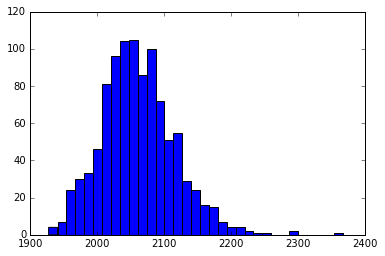

In [42]:
plt.hist(Q_value,bins='auto')
plt.show()

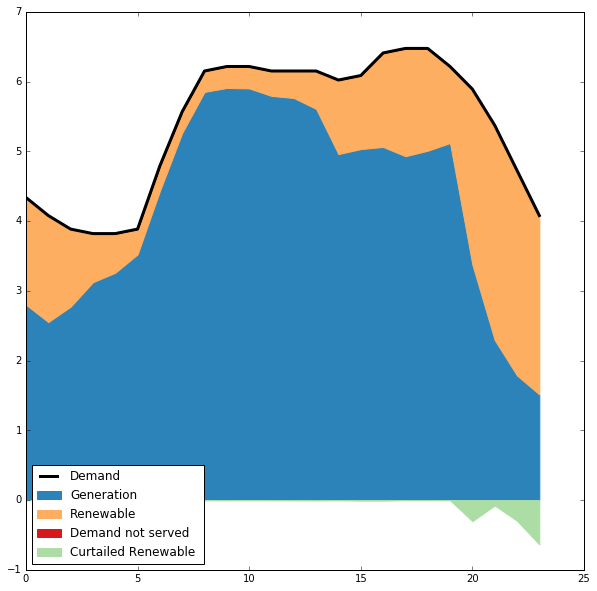

In [32]:
plot_demand(p=np.mean(p_value,0),load=np.mean(load_value,0),s=np.mean(s_value,0),r=np.mean(scenarios_bus,2),b=b,n_h=n_h)

Nuclear
IGCC
Coal
CCGT
OCGT


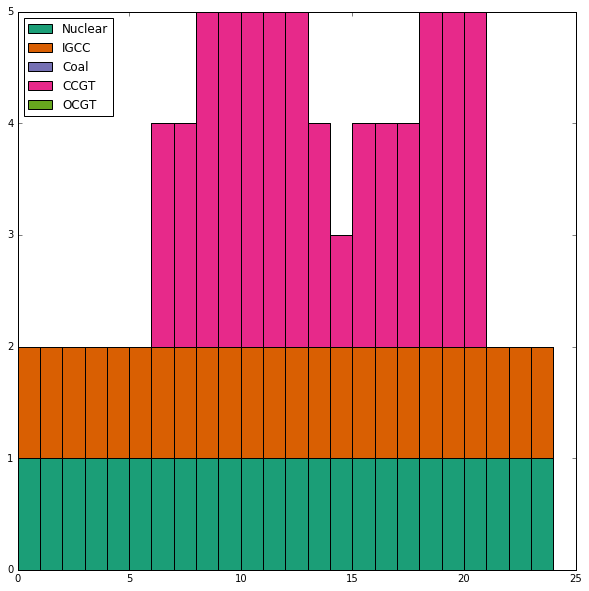

In [52]:
gen_tech=['CCGT', 'CCGT', 'CCGT', 'IGCC', 'Nuclear'], 

sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
N = n_h
ind = np.arange(N)  # the x locations for the groups
width = 1
aux=[]
aux.append(np.zeros(N).T)
cumsum_aux=np.zeros(N)
fig, ax = plt.subplots(figsize=(10,10))
# rects = ax.bar(ind, strategy1_optMean, width, color=color[0])
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for idx,name in enumerate(sorted_name_techno):
    print name
    aux.append(np.array([np.sum(np.ceil(o_test[j,i]) for j in range (num_p) if gen_tech[0][j]==name) for i in range(n_h)]))
    cumsum_aux=np.cumsum(aux,0)
#     print aux[-1]
    rects = ax.bar(ind, aux[idx+1], width, color=colors[idx],bottom=cumsum_aux[idx])
plt.legend(sorted_name_techno,loc='best')  
plt.show()


In [26]:
scenarios_bus[0,0,:]

array([ 0.19903695,  0.21210064,  0.29808394, ...,  0.35351166,
        0.35422405,  0.36606628])